In [1]:
import collections
import itertools
import functools
import os
import time

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize

import matplotlib.pyplot as plt
import matplotlib
%config InlineBackend.figure_format='retina'
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath,amssymb}',
})

import dclf

from tqdm.auto import tqdm

tracker = dclf.ParamTracker()
param = tracker.store

## Read data and select learners

In [2]:
lcdb_df = pd.read_csv(os.path.expanduser('~/Documents/data/delegated_classification/lcdb/database/database-accuracy.csv'))
lcdb_df.head()

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,traintime,score_train,score_valid,score_test
0,44,SVC_linear,16,461,0,0,0.0024,0.8750,0.7440,0.7072
1,44,SVC_linear,23,461,0,0,0.0014,0.9565,0.7222,0.6876
2,44,SVC_linear,32,461,0,0,0.0017,0.9375,0.7295,0.7180
3,44,SVC_linear,45,461,0,0,0.0023,0.9778,0.8237,0.8048
4,44,SVC_linear,64,461,0,0,0.0033,0.7812,0.6280,0.6508


In [3]:
build_cdp = lambda learner, openmlid, m: (
    lcdb_df
    .query('openmlid==@openmlid and learner==@learner')
    .groupby('size_train')
    ['score_test']
    .agg(list)
    .pipe(
        dclf.BootstrappedBinomialMixtureContractDesignProblem.from_series,
        m=m,
        ensure_zero_cost_action=True,
    )
)

In [4]:
selected_openmlid = dclf.mnist_openmlid
learners = list(dclf.lcdb_learner_names)

<Axes: xlabel='size_train'>

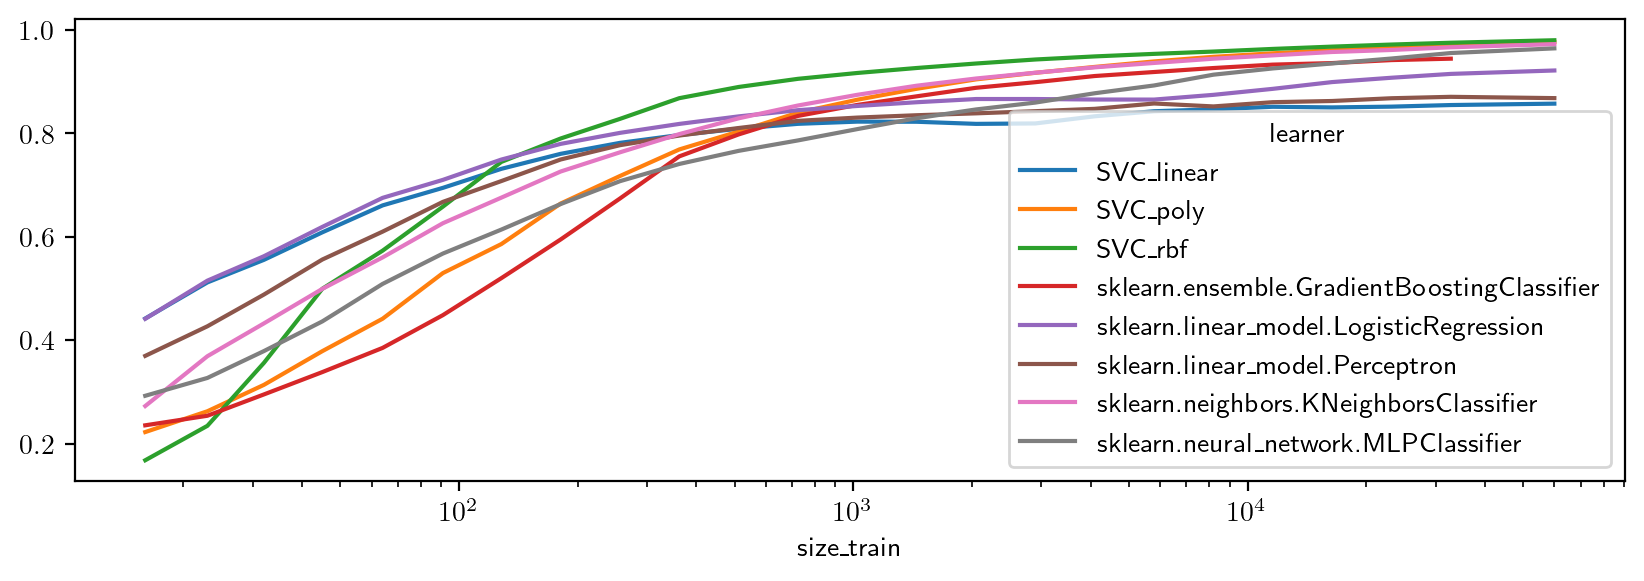

In [5]:
(
    lcdb_df
    .query('openmlid==@selected_openmlid and learner in @learners')
    .groupby(['size_train','learner'])
    ['score_test']
    .mean()
    .unstack()
    .plot.line(figsize=(10,3), logx=True)
)

## Compute grid

In [6]:
lp_results = []

contracts = {
    'lp': dclf.MinBudgetContract.design,
    'threshold': functools.partial(
        dclf.FullEnumerationContract.design,
        monotone=True,
    ),
    'all_or_nothing': functools.partial(
        dclf.FullEnumerationContract.design,
        monotone=False,
    ),
}

def measure_time(f):
    def g(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        dt = end-start
        return result, dt
    return g

EPS = 1e-6

is_monotone = lambda t, eps=EPS: (np.diff(t)>=-eps).all()

def is_threshold(t, eps=EPS):
    close_to_max = t>t.max()-eps
    close_to_min = t<t.min()+eps
    two_distinct_values = (close_to_min | close_to_max).all()
    no_mix = np.arange(len(t))[close_to_max].min() > np.arange(len(t))[close_to_min].max()
    return two_distinct_values and no_mix 

selected_m = param(10,'selected_m')

def is_mlrp(f_ij, eps=EPS):
    n = len(f_ij)
    q = f_ij[n-1]
    for i in range(1,n-1):
        p = f_ij[i]
        if not (np.diff(q/p)>=-eps).all():
            return False
    return True


for learner in tqdm(learners, position=0):
    cdp = build_cdp(learner, selected_openmlid, m=selected_m)
    for target,c in enumerate(
        tqdm(cdp.cost, position=1, leave=False),
    ):
        if cdp.cost[target]<=param(100,'min_cost'):
            continue
        if cdp.mean_acc[target] <= cdp.mean_acc[:target].max() + 1e-6:
            continue
        mlrp = is_mlrp(cdp.f_ij[:target+1])
        prev_mlrp = is_mlrp(cdp.f_ij[target-1:target+1])
        for contract_type, design_func in contracts.items():
            out = {
                'learner': learner,
                'cdp': cdp,
                'target_action': target,
                'target_acc': cdp.mean_acc[target],
                'n': c,
                'is_mlrp': mlrp,
                'is_prev_mlrp': prev_mlrp,
                'contract_type': contract_type,
                'contract': None,
                'is_feasible': False,
            }

            try:
                contract, dt = measure_time(design_func)(
                    design_problem=cdp,
                    target_action=target,
                )
                out['contract'] = contract
                if contract['t'][0]==None:
                    raise RuntimeError
                response = dclf.get_agent_response(cdp,contract['t'])
                if response.selected_action<target:
                    raise RuntimeError
                out['is_feasible'] = True
                out['t'] = contract['t']
                out['is_monotone'] = is_monotone(contract['t'])
                out['is_threshold'] = is_threshold(contract['t'])
                out['B'] = contract['t'].max()
                out['time'] = dt
            except (ZeroDivisionError, RuntimeError) as e:
                out['error'] = e

            lp_results.append(out)

lp_results_df = pd.DataFrame(lp_results)
lp_results_df.head()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

,learner,cdp,target_action,target_acc,n,is_mlrp,is_prev_mlrp,contract_type,contract,is_feasible,t,is_monotone,is_threshold,B,time
0,sklearn.neural_network.MLPClassifier,BootstrappedBinomialMixtureContractDesignProbl...,7,0.613696,128,True,True,lp,"{'primal_model': [None], 'primal_result': {'Pr...",True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408767330...",True,True,318.774088,0.148194
1,sklearn.neural_network.MLPClassifier,BootstrappedBinomialMixtureContractDesignProbl...,7,0.613696,128,True,True,threshold,"{'t': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408...",True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408767330...",True,True,318.774088,0.000192
2,sklearn.neural_network.MLPClassifier,BootstrappedBinomialMixtureContractDesignProbl...,7,0.613696,128,True,True,all_or_nothing,"{'t': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408...",True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 318.77408767330...",True,True,318.774088,0.011875
3,sklearn.neural_network.MLPClassifier,BootstrappedBinomialMixtureContractDesignProbl...,8,0.663096,181,True,True,lp,"{'primal_model': [None], 'primal_result': {'Pr...",True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 406.264877...",True,True,406.264877,0.077051
4,sklearn.neural_network.MLPClassifier,BootstrappedBinomialMixtureContractDesignProbl...,8,0.663096,181,True,True,threshold,"{'t': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 406....",True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 406.264877...",True,True,406.264877,0.000161


## Analysis

In [7]:
ratio = lambda col1, col2, offset=0: (lambda df: df[col1]/df[col2]+offset)

new_cols = {
    f'ratio_{contract_type}': ratio(contract_type,'lp',-1)
    for contract_type in contracts
    if contract_type!='lp'
}
ratio_s = (
    lp_results_df
    .query('is_feasible')
    .pivot(
        index=['learner','n'],
        columns='contract_type',
        values='B',
    )
    .dropna(subset='lp')
    .assign(**new_cols)
    .iloc[:,-len(new_cols):]
    .groupby(level=0)
    .mean()
)
(ratio_s*100).style.format('{:.2f}')

contract_type,ratio_threshold,ratio_all_or_nothing
learner,,
SVC_linear,1.14,0.74
SVC_poly,0.24,0.24
SVC_rbf,0.04,0.04
sklearn.ensemble.GradientBoostingClassifier,0.71,0.71
sklearn.linear_model.LogisticRegression,0.76,0.02
sklearn.linear_model.Perceptron,0.00,0.00
sklearn.neighbors.KNeighborsClassifier,-0.00,-0.00
sklearn.neural_network.MLPClassifier,0.04,0.04


In [8]:
attrib_s = lambda attrib: (
    lp_results_df
    .query('is_feasible')
    .pivot(
        index=['learner','n'],
        columns='contract_type',
        values=attrib,
    )
    ['lp']
    .astype(float)
    .groupby(level=0)
    .mean()
    .rename(f'pct_{attrib}')
)

attrib_s('is_monotone')


learner
SVC_linear                                     0.857143
SVC_poly                                       0.944444
SVC_rbf                                        0.888889
sklearn.ensemble.GradientBoostingClassifier    1.000000
sklearn.linear_model.LogisticRegression        0.937500
sklearn.linear_model.Perceptron                0.937500
sklearn.neighbors.KNeighborsClassifier         1.000000
sklearn.neural_network.MLPClassifier           1.000000
Name: pct_is_monotone, dtype: float64

In [9]:
col_names = {
    'pct_is_mlrp': '\\% MLRP',
    'pct_is_monotone': '\\% Monotone',
    'pct_is_threshold': '\\% Threshold',
    'ratio_threshold': 'Excess cost: threshold',
    'ratio_all_or_nothing': 'Excess cost: all-or-nothing',
}
format_pct = lambda x: f'{x*100:.3g}\\%'
format_rel = lambda x: f'{(0 if abs(x)<1e-5 else x)*100:.2f}\\%'
formatters = {
    'pct_is_mlrp': format_pct,
    'pct_is_monotone': format_pct,
    'pct_is_threshold': format_pct,
    'ratio_threshold': format_rel,
    'ratio_all_or_nothing': format_rel,
}

out_df = (
    pd.concat(
        [
            ratio_s,
            attrib_s('is_mlrp'),
            attrib_s('is_monotone'),
            attrib_s('is_threshold'),
            
        ],
        axis=1,
    )
    .loc[learners,list(col_names)]
    .rename(
        col_names,
        axis=1,
    )
    .rename(
        dclf.lcdb_learner_names
    )
    .style
    .format(
        {col_names[col]: formatters[col] for col in col_names},
    )
)
print(out_df.to_latex())
out_df

\begin{tabular}{lrrrrr}
 & \% MLRP & \% Monotone & \% Threshold & Excess cost: threshold & Excess cost: all-or-nothing \\
learner &  &  &  &  &  \\
MLP & 100\% & 100\% & 94.4\% & 0.04\% & 0.04\% \\
GBDT & 100\% & 100\% & 82.4\% & 0.71\% & 0.71\% \\
Logistic Regression & 93.8\% & 93.8\% & 93.8\% & 0.76\% & 0.02\% \\
Perceptron & 68.8\% & 93.8\% & 93.8\% & 0.00\% & 0.00\% \\
Linear SVM & 71.4\% & 85.7\% & 85.7\% & 1.14\% & 0.74\% \\
Polynomial SVM & 100\% & 94.4\% & 88.9\% & 0.24\% & 0.24\% \\
RBF SVM & 100\% & 88.9\% & 83.3\% & 0.04\% & 0.04\% \\
K-NN & 100\% & 100\% & 100\% & 0.00\% & 0.00\% \\
\end{tabular}



,\% MLRP,\% Monotone,\% Threshold,Excess cost: threshold,Excess cost: all-or-nothing
learner,,,,,
MLP,100\%,100\%,94.4\%,0.04\%,0.04\%
GBDT,100\%,100\%,82.4\%,0.71\%,0.71\%
Logistic Regression,93.8\%,93.8\%,93.8\%,0.76\%,0.02\%
Perceptron,68.8\%,93.8\%,93.8\%,0.00\%,0.00\%
Linear SVM,71.4\%,85.7\%,85.7\%,1.14\%,0.74\%
Polynomial SVM,100\%,94.4\%,88.9\%,0.24\%,0.24\%
RBF SVM,100\%,88.9\%,83.3\%,0.04\%,0.04\%
K-NN,100\%,100\%,100\%,0.00\%,0.00\%
